In [1]:
#extract the zip file

!unzip /content/archive_3.zip -d /content/extracted_files


Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted_files/data/cloudy/train_23566.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23598.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23608.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23634.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23636.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23646.jpg  
  inflating: /content/extracted_files/data/cloudy/train_2366.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23664.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23706.jpg  
  inflating: /content/extracted_files/data/cloudy/train_2380.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23805.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23806.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23826.jpg  
  inflating: /content/extracted_files/data/cloudy/train_23843.jpg  

In [26]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import layers, models

In [27]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels


def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


def create_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

In [28]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= 40)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= 40)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= 40)
    return train_gen, valid_gen, test_gen


dir = '/content/extracted_files/data'

df = create_df(dir)
train_df, test_valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

# Get Generators
batch_size = 200
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 4504 validated image filenames belonging to 4 classes.
Found 564 validated image filenames belonging to 4 classes.
Found 563 validated image filenames belonging to 4 classes.


In [29]:
class_labels = list(train_gen.class_indices.keys())

In [30]:
print(class_labels)

['cloudy', 'desert', 'green_area', 'water']


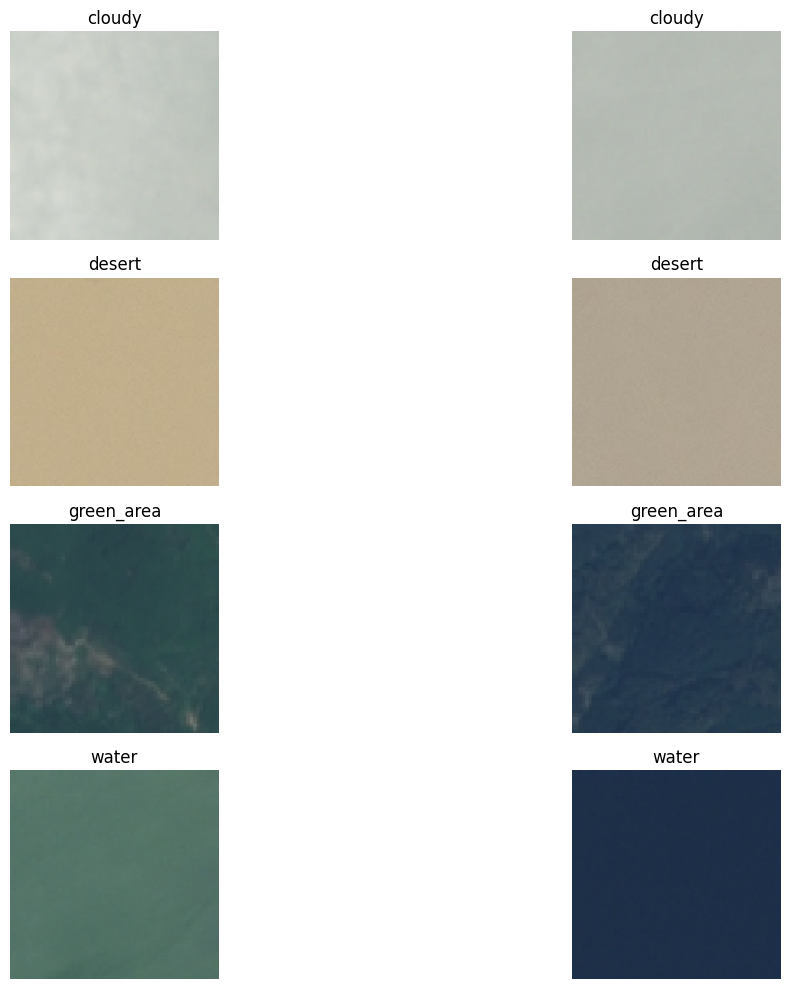

In [31]:
# prompt: plot images form each class using sns

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_gen, valid_gen, and test_gen are already defined as in your provided code.

# Get a batch of images and labels from the training generator
images, labels = next(train_gen)

# Number of classes
num_classes = len(class_labels)

# Number of images to display per class
images_per_class = 2

plt.figure(figsize=(15, 10))

for class_index in range(num_classes):
    class_label = class_labels[class_index]

    # Find indices of images belonging to the current class in the batch
    class_indices = np.where(np.argmax(labels, axis=1) == class_index)[0]

    # Display up to images_per_class images from the current class
    for i in range(min(images_per_class, len(class_indices))):
        image_index = class_indices[i]
        plt.subplot(num_classes, images_per_class, class_index * images_per_class + i + 1)
        plt.imshow(images[image_index].astype('uint8'))  # Ensure correct data type for display
        plt.title(f"{class_label}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)

(4504, 2)
(563, 2)
(564, 2)


In [33]:
# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4
# Build the CNN model
model = models.Sequential()

# Convolutional layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
# Convolutional layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
# Convolutional layer 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Flatten the output
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(512, activation='relu'))

# Output layer
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,604 (73.49 MB)

 Trainable params: 19,265,476 (73.49 MB)

 Non-trainable params: 128 (512.00 B)

In [34]:
# prompt: build a callback function

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [35]:
history = model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[callbacks] , verbose= 1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 252ms/step - accuracy: 0.6666 - loss: 3.0313 - val_accuracy: 0.5301 - val_loss: 1.5460
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.8410 - loss: 0.4049 - val_accuracy: 0.8564 - val_loss: 0.3538
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.8629 - loss: 0.3455 - val_accuracy: 0.7819 - val_loss: 0.4509
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.8353 - loss: 0.4133 - val_accuracy: 0.8936 - val_loss: 0.2715
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.8725 - loss: 0.3214 - val_accuracy: 0.7713 - val_loss: 0.6232
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.8839 - loss: 0.3086 - val_accuracy: 0.8014 - val_loss: 0.3897
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8751 - loss: 0.2977 - val_accuracy: 0.7713 - val_loss: 0.4702
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8918 - loss: 0.3007 - val_accura

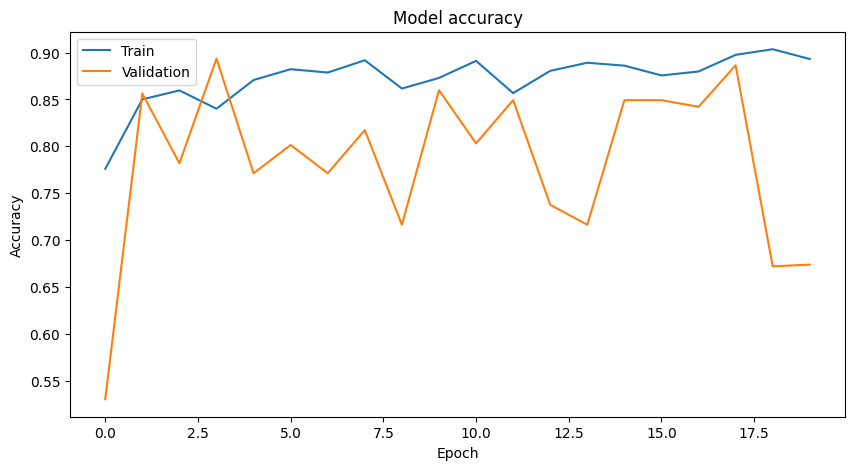

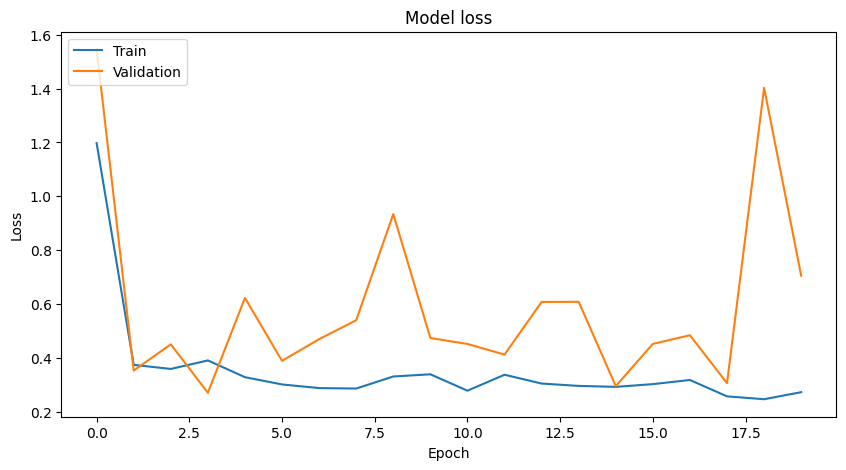

In [36]:
# plot the accuracy and the loss and validatin accuracy and loss

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
model.evaluate(test_gen)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6821 - loss: 0.7253


[0.7246930003166199, 0.6838365793228149]

In [38]:
model.predict(test_gen)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


array([[2.76029199e-01, 1.72372833e-01, 2.58990437e-01, 2.92607605e-01],
       [1.81866039e-06, 7.39685444e-16, 7.17194689e-06, 9.99991059e-01],
       [9.92764771e-01, 7.23358057e-03, 7.63029817e-08, 1.52144287e-06],
       ...,
       [2.76029199e-01, 1.72372833e-01, 2.58990437e-01, 2.92607605e-01],
       [2.26503760e-01, 5.45793818e-03, 1.06407285e-01, 6.61631107e-01],
       [2.76029199e-01, 1.72372833e-01, 2.58990437e-01, 2.92607605e-01]],
      dtype=float32)

In [40]:
# prompt: save the model as hdf5

# Save the model as an HDF5 file
model.save('my_model_2.h5')

In [41]:
model_new = tf.keras.models.load_model('my_model_2.h5')

In [42]:
model_new.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,606 (73.49 MB)

 Trainable params: 19,265,476 (73.49 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2 (12.00 B)

In [43]:
loss , acc = model_new.evaluate(test_gen)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.6821 - loss: 0.7253
